# Equação do Calor 2D

Vamos resolver numericamente a equação do calor a 2D:

\begin{align*}
\frac{\partial T}{\partial t} = D \left[\frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2}\right]
\end{align*}

# Imports

In [6]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image
from typing import Callable

# Método FTCS

In [7]:
def calor2DFTCS(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dtMult: float = 0.99):
    """
        Evolui a equação do calor por um tempo `T` com o método FTCS com condições iniciais `ci` evoluindo apenas os pontos onde `mask == True`.

        O coeficiente de difusão é `D` e o espaçamento entre pontos da grelha no espaço e no tempo é `dx`, `dy`. O intervalo de tempo usado é `dtMult` * (menor dt para o qual o método é estável)

        Caso `terminar` seja especificado termina a simulação quando o valor mínimo da temperatura ultrapassa `terminar`.

        Assume que os pontos na fronteira de `mask` são `False` (assumimos que a temperatura na fronteira está fixa).
    """

    # Copiar condições iniciais
    now = np.copy(ci)
    nex = np.copy(ci)

    # Criar o passo no tempo
    dt = 1 / (2 * D * (1/dx**2 + 1/dy**2)) * dtMult
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Evoluir no tempo
    i = 0
    while i < iMax:
        nex[1:-1, 1:-1] = now[1:-1, 1:-1] + mask[1:-1, 1:-1] * (Fx * (now[2:, 1:-1] + now[:-2, 1:-1] - 2 * now[1:-1, 1:-1]) + Fy * (now[1:-1, 2:] + now[1:-1, :-2] - 2 * now[1:-1, 1:-1]))
            
        i += 1
        now = np.copy(nex)
    
    return now, i * dt

# Testar

Vamos aquecer um leitão!

In [8]:
# Parâmetros do Problema (Unidades SI, Temperatura em Celsius)

# Dimensões e Temperatura do Forno
FORNOX = 0.60
FORNOY = 0.60
FORNOT = 150 + 273.15

# Dimensões e Temperatura do Leitão
LEITAOX = 0.45
LEITAOTI = 6
LEITAOTF = 70

# Coeficiente de difusão
DIF = 1.45e-7


# Parâmetros da Simulação

# Número de pontos a usar
NX = 401
NY = 401

# Espaçamento entre pontos da grelha
DX = FORNOX / (NX-1)
DY = FORNOY / (NY-1)

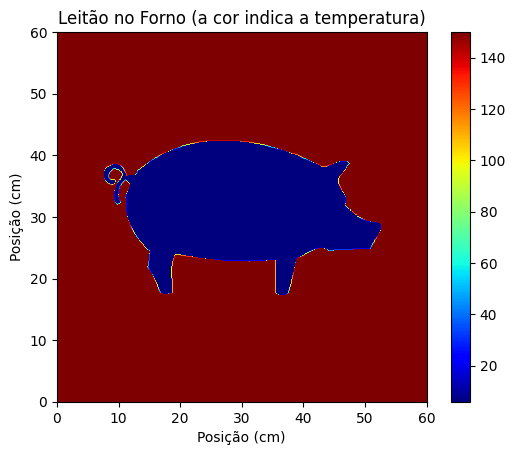

In [9]:
# Importar a imagem
leitao = Image.open("leitao_bw.png")

# Tamanho da imagem
XMAX, YMAX = leitao.size
LEITAOY = LEITAOX * (YMAX / XMAX)

# Espaçamento entre pontos da grelha da imagem do leitão
NXLEITAO = int(LEITAOX / FORNOX * NX)
NYLEITAO = int(LEITAOY / FORNOY * NY)

DXLEITAO = LEITAOX / (NXLEITAO - 1)
DYLEITAO = LEITAOY / (NYLEITAO - 1)

# Transformar em array
ll = np.array(leitao)

# Posicionamos o leitão de forma a que fique no centro do forno
NXI = (NX - NXLEITAO) // 2
NYI = (NY - NYLEITAO) // 2

XI = NXI * DX
YI = NYI * DY

# Interpolar a imagem png para obter a resolução desejada
xx = np.arange(XMAX)
yy = np.arange(YMAX)
coords = []

MULTX = DXLEITAO * NXLEITAO / XMAX
MULTY = DYLEITAO * NYLEITAO / YMAX
for i in range(XMAX):
    for j in range(YMAX):
        coords += [(XI + i * MULTX, YI + j * MULTY)]

interpol = sp.interpolate.LinearNDInterpolator(coords, ll.flatten(order="F"), fill_value=0)

# Colocar o leitão dentro do forno e definir a grelha
xx = np.linspace(0, FORNOX, NX)
yy = np.linspace(0, FORNOY, NY)
mx, my = np.meshgrid(xx, yy)
ll = interpol(mx, my)

# Fazer a máscara que indica onde está o leitão
leitao = ll > 240

# Aplicar as condições iniciais (que incluem as condições fronteira graças a máscara que criamos)
forno = np.zeros_like(ll)
forno[:, :] = 150
forno[leitao] = 6

# Ver a imagem
plt.imshow(forno, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title("Leitão no Forno (a cor indica a temperatura)")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

## Método FTCS

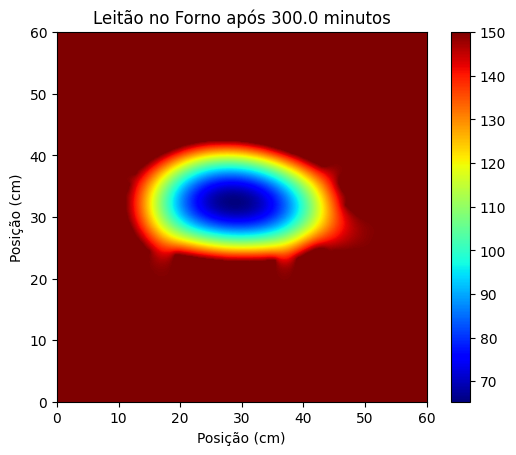

In [10]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação (guardar o estado a cada SAMPLE iterações do método)
cozinhado, tempo = calor2DFTCS(5 * 3600, fornoC, leitaoC, DIF, DX, DY)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()